In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pypiahmad/landslide4sense-challenge")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/landslide4sense-challenge


Keys: ['img']
(128, 128, 14) float64


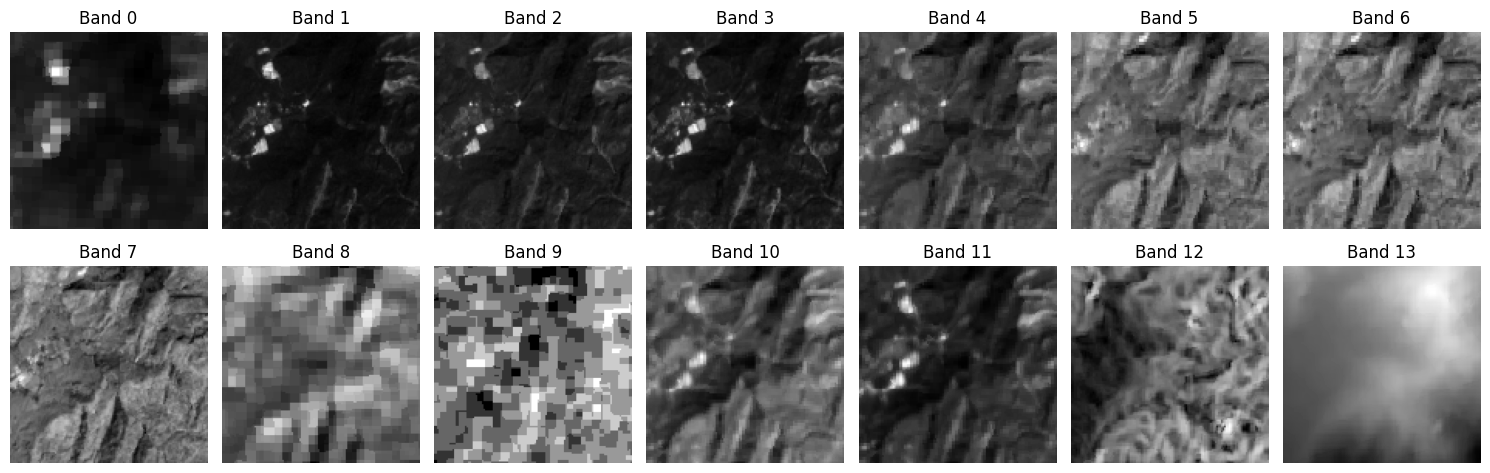

In [3]:
import h5py
import matplotlib.pyplot as plt
with h5py.File("/kaggle/input/landslide4sense-challenge/TrainData/img/image_1.h5", "r") as f:
    # List all groups/datasets
    print("Keys:", list(f.keys()))
    
    # Access a dataset
    img = f["img"][:]
    print(img.shape, img.dtype)
fig, axes = plt.subplots(2, 7, figsize=(15, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(img[:, :, i], cmap="gray")
    ax.set_title(f"Band {i}")
    ax.axis("off")

plt.tight_layout()
plt.show()


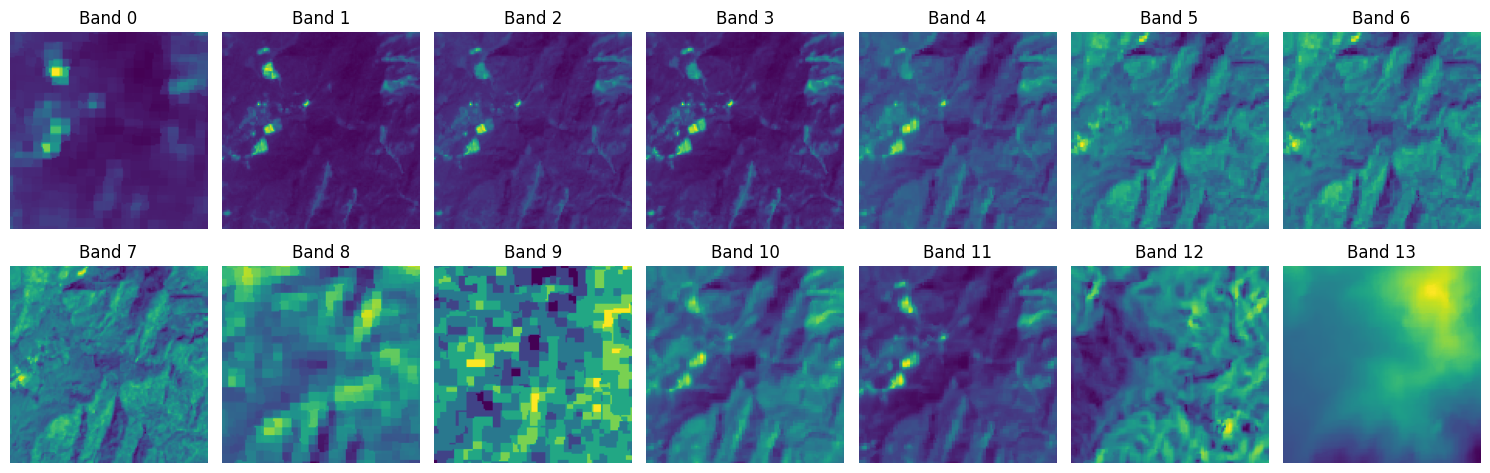

In [4]:
fig, axes = plt.subplots(2, 7, figsize=(15, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(img[:, :, i], cmap="viridis")
    ax.set_title(f"Band {i}")
    ax.axis("off")

plt.tight_layout()
plt.show()

Keys: ['mask']
(128, 128) uint8


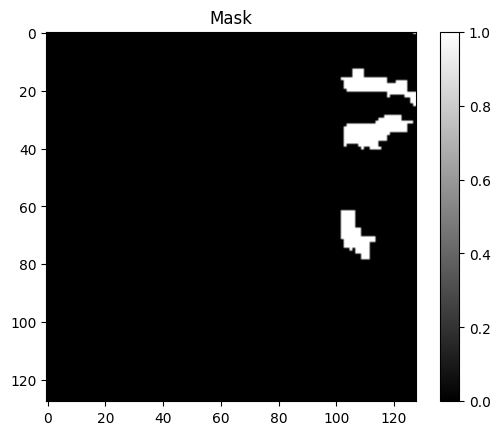

In [5]:
with h5py.File("/kaggle/input/landslide4sense-challenge/TrainData/mask/mask_1.h5", "r") as f:
    # List all groups/datasets
    print("Keys:", list(f.keys()))
    
    # Access a dataset
    mask = f["mask"][:]
    print(mask.shape, mask.dtype)
plt.imshow(mask, cmap="gray")
plt.colorbar()
plt.title("Mask")
plt.show()

(128, 128, 14)
(128, 128)


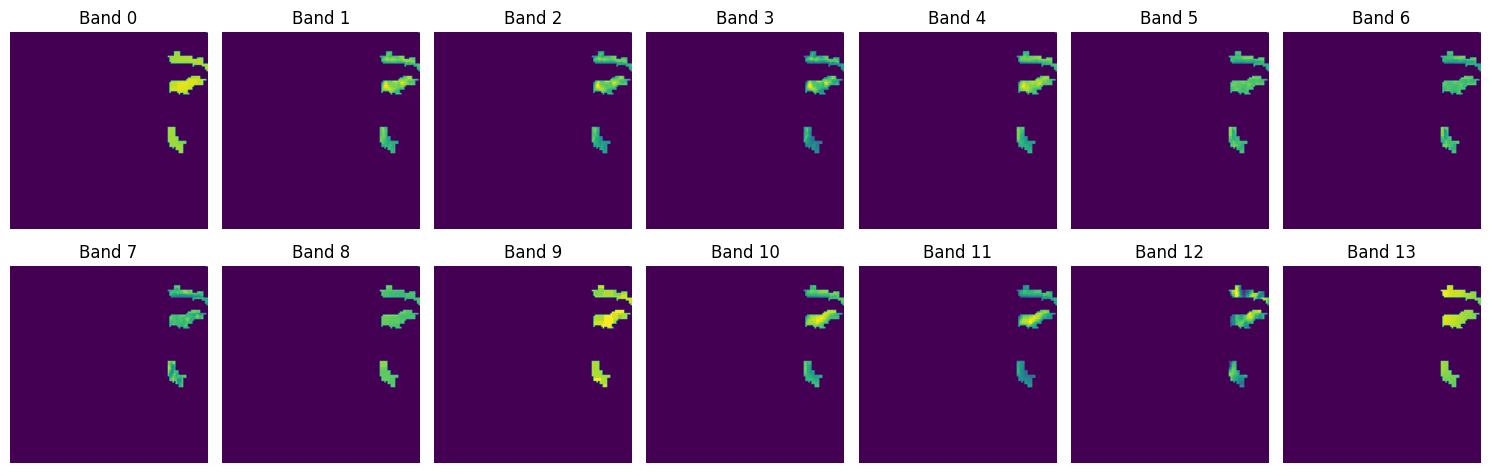

In [6]:
print(img.shape)   # should be (128,128,14)
print(mask.shape)  # should be (128,128)

# Expand mask to 3D so broadcasting works
mask_3d = np.expand_dims(mask, axis=-1)   # (128,128,1)

# Apply elementwise multiplication
result = img * mask_3d   # (128,128,14)

fig, axes = plt.subplots(2, 7, figsize=(15, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(result[:, :, i], cmap="viridis")
    ax.set_title(f"Band {i}")
    ax.axis("off")

plt.tight_layout()
plt.show()


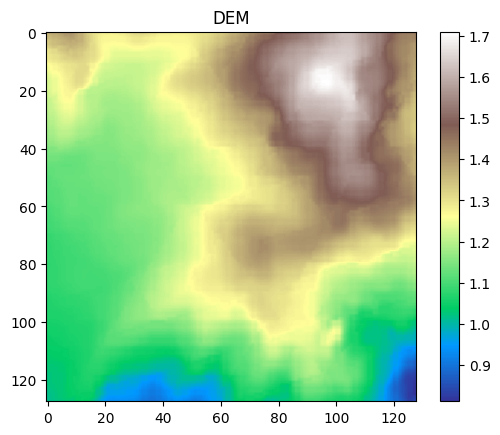

In [7]:
dem = img[:,:, -1]   # take last band (height map)
plt.imshow(dem, cmap="terrain")
plt.colorbar()
plt.title("DEM")
plt.show()
# Flattened grid already exists: points, dem, labels


In [8]:
# Get x,y grid
rows, cols = dem.shape
X, Y = np.meshgrid(np.arange(cols), np.arange(rows))

# Flatten into point cloud
points = np.stack([X.flatten(), Y.flatten(), dem.flatten()], axis=1)  # (N,3)

print("Point cloud shape:", points.shape)


Point cloud shape: (16384, 3)


In [9]:
labels = mask.flatten()   # 0=stable, 1=landslide
print("Labels:", np.unique(labels))

Labels: [0 1]


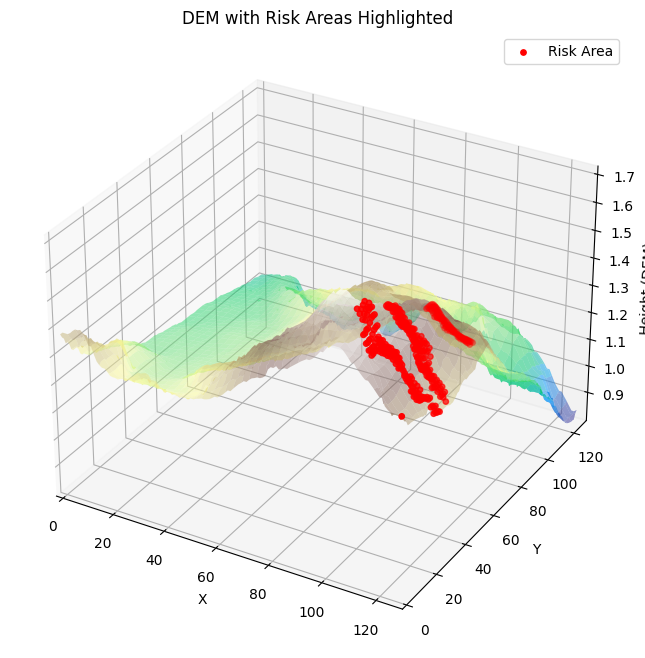

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Flattened grid already exists: points, dem, labels

# Create X, Y meshgrid
rows, cols = dem.shape
X, Y = np.meshgrid(np.arange(cols), np.arange(rows))

# Filter positive (risk) points
positive_mask = labels == 1
risk_points = points[positive_mask]

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

# Plot full DEM as semi-transparent surface
ax.plot_surface(X, Y, dem, cmap='terrain', alpha=0.5, edgecolor='none')

# Overlay risk points in red
ax.scatter(risk_points[:,0], risk_points[:,1], risk_points[:,2],
           c='red', marker='o', s=15, label="Risk Area")

# Set same scaling
ax.set_xlim(0, cols-1)
ax.set_ylim(0, rows-1)
ax.set_zlim(dem.min(), dem.max())

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Height (DEM)")
ax.set_title("DEM with Risk Areas Highlighted")
ax.legend()

plt.show()


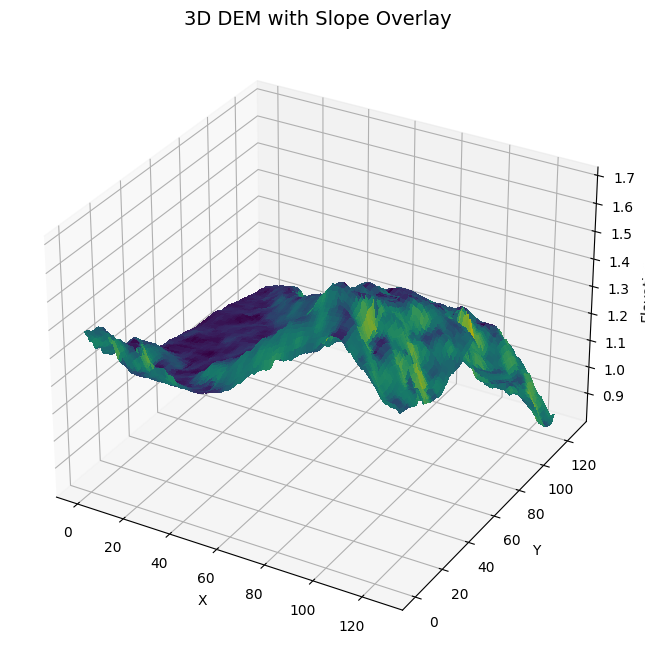

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Suppose you have DEM and slope as numpy arrays of same shape (H, W)
# Replace these with your real arrays
dem = img[:,:,13]      # DEM heights
slope = img[:,:,12]  # slope values

# Create X, Y coordinates
X, Y = np.meshgrid(np.arange(dem.shape[1]), np.arange(dem.shape[0]))

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# Normalize slope for colormap
slope_norm = slope / np.nanmax(slope)

# Plot DEM surface with slope as color overlay
surf = ax.plot_surface(
    X, Y, dem, 
    facecolors=plt.cm.viridis(slope_norm),
    rstride=1, cstride=1, linewidth=0, antialiased=False
)

ax.set_title("3D DEM with Slope Overlay", fontsize=14)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Elevation")

plt.show()

In [12]:
import os
import h5py
import torch
from torch.utils.data import Dataset, DataLoader

class LandslideDataset(Dataset):
    def __init__(self, img_folder, mask_folder=None, transform=None):
        self.img_folder = img_folder
        self.mask_folder = mask_folder
        self.transform = transform
        self.img_files = sorted([f for f in os.listdir(img_folder) if f.endswith('.h5')])
        
        if mask_folder:
            self.mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith('.h5')])
            assert len(self.img_files) == len(self.mask_files), "Number of images and masks must match"
        else:
            self.mask_files = [None] * len(self.img_files)

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_folder, self.img_files[idx])
        mask_path = os.path.join(self.mask_folder, self.mask_files[idx]) if self.mask_folder else None
    
        # Load image
        with h5py.File(img_path, 'r') as f:
            image = f['img'][()]  # (H, W, C) or (C, H, W)
    
        # Load mask if available
        mask = None
        if mask_path:
            with h5py.File(mask_path, 'r') as f:
                mask = f['mask'][()]  # (H, W)
    
        # Convert to torch tensors
        if image.ndim == 3:
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # (C,H,W)
        else:
            image = torch.tensor(image, dtype=torch.float32)
    
        if mask is not None:
            mask = torch.tensor(mask, dtype=torch.long)
    
        # Bandwise normalization
        if image.ndim == 3:  # (C,H,W)
            for c in range(image.shape[0]):
                band = image[c]
                image[c] = (band - band.min()) / (band.max() - band.min() + 1e-8)
    
        # Apply transforms if any
        if self.transform:
            image = self.transform(image)
    
        # Always return tuple for consistency
        return (image, mask) if mask is not None else (image, None)


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [16]:
from torch.utils.data import DataLoader, random_split

train_img_folder = "/kaggle/input/landslide4sense-challenge/TrainData/img"
train_mask_folder = "/kaggle/input/landslide4sense-challenge/TrainData/mask"

# Dataset
full_dataset = LandslideDataset(train_img_folder, train_mask_folder)

# Split lengths
total_len = len(full_dataset)
train_len = int(0.8 * total_len)
val_len = total_len - train_len

# Split dataset
train_dataset, val_dataset = random_split(full_dataset, [train_len, val_len])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

# Test iteration
for images, masks in train_loader:
    print(images.shape, masks.shape)
    break
print(len(train_loader))
print(len(valid_loader))

torch.Size([16, 14, 128, 128]) torch.Size([16, 128, 128])
190
48


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

# --- Double Convolution Block (Conv -> BN -> ReLU -> Conv -> BN -> ReLU) ---
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

# --- UNet Model ---
class UNet(nn.Module):
    def __init__(self, in_channels=14, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.encoder_layers = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        prev_channels = in_channels
        for feature in features:
            self.encoder_layers.append(DoubleConv(prev_channels, feature))
            prev_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        bottleneck_channels = features[-1]*2

        # Decoder
        self.upconvs = nn.ModuleList()
        self.decoder_layers = nn.ModuleList()
        rev_features = features[::-1]  # reverse
        in_ch = bottleneck_channels
        for feature in rev_features:
            self.upconvs.append(nn.ConvTranspose2d(in_ch, feature, kernel_size=2, stride=2))
            self.decoder_layers.append(DoubleConv(feature*2, feature))  # skip connection doubles channels
            in_ch = feature

        # Final layer
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder
        for enc in self.encoder_layers:
            x = enc(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]  # reverse for decoder

        # Decoder
        for idx in range(len(self.upconvs)):
            x = self.upconvs[idx](x)
            skip = skip_connections[idx]

            # Handle size mismatch
            if x.shape != skip.shape:
                x = F.interpolate(x, size=skip.shape[2:])

            x = torch.cat((skip, x), dim=1)
            x = self.decoder_layers[idx](x)

        return self.final_conv(x)

# --- Example usage ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=14, out_channels=1).to(device)

# Test with dummy input
dummy = torch.randn(1, 14, 128, 128).to(device)
out = model(dummy)
print("Output shape:", out.shape)
print("Total parameters:", sum(p.numel() for p in model.parameters()))
summary(model, input_size=(1, 14, 128, 128))

Output shape: torch.Size([1, 1, 128, 128])
Total parameters: 31049857


Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 1, 128, 128]          --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-1                   [1, 64, 128, 128]         --
│    │    └─Sequential: 3-1              [1, 64, 128, 128]         45,312
├─MaxPool2d: 1-2                         [1, 64, 64, 64]           --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-2                   [1, 128, 64, 64]          --
│    │    └─Sequential: 3-2              [1, 128, 64, 64]          221,952
├─MaxPool2d: 1-4                         [1, 128, 32, 32]          --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-3                   [1, 256, 32, 32]          --
│    │    └─Sequential: 3-3              [1, 256, 32, 32]          886,272
├─MaxPool2d: 1-6                         [1,

In [24]:
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

def train_unet(model, train_loader, val_loader, device, num_epochs=20, lr=1e-3):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        # Training loop with tqdm
        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training", leave=False)
        for imgs_l, masks_l in loop:
            imgs_l = imgs_l.to(device)
            masks_l = masks_l.unsqueeze(1).to(device).float()  # shape (B,1,H,W)

            optimizer.zero_grad()
            outputs_l = model(imgs_l)
            
            # If output has 2 channels (not needed for 1-channel UNet)
            if outputs_l.shape[1] == 2:
                outputs_l = outputs_l[:,1:2,:,:]

            loss_l = criterion(outputs_l, masks_l)
            loss_l.backward()
            optimizer.step()

            train_loss += loss_l.item()
            loop.set_postfix(loss=loss_l.item())

        avg_train_loss = train_loss / len(train_loader)

        # Validation loop with tqdm
        model.eval()
        val_loss = 0.0
        loop_val = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation", leave=False)
        with torch.no_grad():
            for imgs_v, masks_v in loop_val:
                imgs_v = imgs_v.to(device)
                masks_v = masks_v.unsqueeze(1).to(device).float()
                outputs_v = model(imgs_v)

                if outputs_v.shape[1] == 2:
                    outputs_v = outputs_v[:,1:2,:,:]

                loss_v = criterion(outputs_v, masks_v)
                val_loss += loss_v.item()
                loop_val.set_postfix(val_loss=loss_v.item())

        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}] --> Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    print("Training completed!")


In [25]:
train_unet(model,train_loader,valid_loader,device=device)

Epoch [1/20] --> Train Loss: 0.0522, Val Loss: 0.0440


Epoch [2/20] --> Train Loss: 0.0428, Val Loss: 0.0471


Epoch [3/20] --> Train Loss: 0.0406, Val Loss: 0.0372


Epoch [4/20] --> Train Loss: 0.0393, Val Loss: 0.0361


Epoch [5/20] --> Train Loss: 0.0370, Val Loss: 0.0357


Epoch [6/20] --> Train Loss: 0.0357, Val Loss: 0.0346


Epoch [7/20] --> Train Loss: 0.0360, Val Loss: 0.0341


Epoch [8/20] --> Train Loss: 0.0370, Val Loss: 0.0338


Epoch [9/20] --> Train Loss: 0.0346, Val Loss: 0.0386


Epoch [10/20] --> Train Loss: 0.0337, Val Loss: 0.0341


Epoch [11/20] --> Train Loss: 0.0338, Val Loss: 0.0325


Epoch [12/20] --> Train Loss: 0.0336, Val Loss: 0.0323


Epoch [13/20] --> Train Loss: 0.0343, Val Loss: 0.0326


Epoch [14/20] --> Train Loss: 0.0329, Val Loss: 0.0336


Epoch [15/20] --> Train Loss: 0.0327, Val Loss: 0.0339


Epoch [16/20] --> Train Loss: 0.0327, Val Loss: 0.0322


Epoch [17/20] --> Train Loss: 0.0326, Val Loss: 0.0319


Epoch [18/20] --> Train Loss: 0.0315, Val Loss: 0.0320


Epoch [19/20] --> Train Loss: 0.0320, Val Loss: 0.0329


Epoch [20/20] --> Train Loss: 0.0312, Val Loss: 0.0331
Training completed!


In [73]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_predictions_grid(model, dataloader, device, num_batches=10, images_per_batch=2):
    model.eval()
    imgs_list, masks_list, preds_list = [], [], []

    with torch.no_grad():
        batch_count = 0
        for imgs, masks in dataloader:
            imgs = imgs.to(device)
            masks = masks.unsqueeze(1).to(device).float()
            outputs = model(imgs)
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()
            
            B = imgs.shape[0]
            indices = np.random.choice(B, min(images_per_batch, B), replace=False)
            
            for i in indices:
                img_np = imgs[i].cpu().numpy()
                mask_np = masks[i].cpu().numpy().squeeze()
                pred_np = preds[i].cpu().numpy().squeeze()

                # For 14-channel input, show first 3 channels as RGB approximation
                if img_np.shape[0] >= 3:
                    img_show = np.transpose(img_np[:3], (1,2,0))
                    img_show = (img_show - img_show.min()) / (img_show.max() - img_show.min())
                else:
                    img_show = img_np[0]

                imgs_list.append(img_show)
                masks_list.append(mask_np)
                preds_list.append(pred_np)

            batch_count += 1
            if batch_count >= num_batches:
                break

    # Plot all images in a grid
    total_images = len(imgs_list)
    plt.figure(figsize=(15, total_images*1.5))
    for idx in range(total_images):
        plt.subplot(total_images, 3, idx*3 + 1)
        plt.imshow(imgs_list[idx])
        plt.axis('off')
        if idx==0: plt.title("Input")
        
        plt.subplot(total_images, 3, idx*3 + 2)
        plt.imshow(masks_list[idx], cmap='gray')
        plt.axis('off')
        if idx==0: plt.title("Ground Truth")
        
        plt.subplot(total_images, 3, idx*3 + 3)
        plt.imshow(preds_list[idx], cmap='gray')
        plt.axis('off')
        if idx==0: plt.title("Prediction")

    plt.tight_layout()
    plt.show()

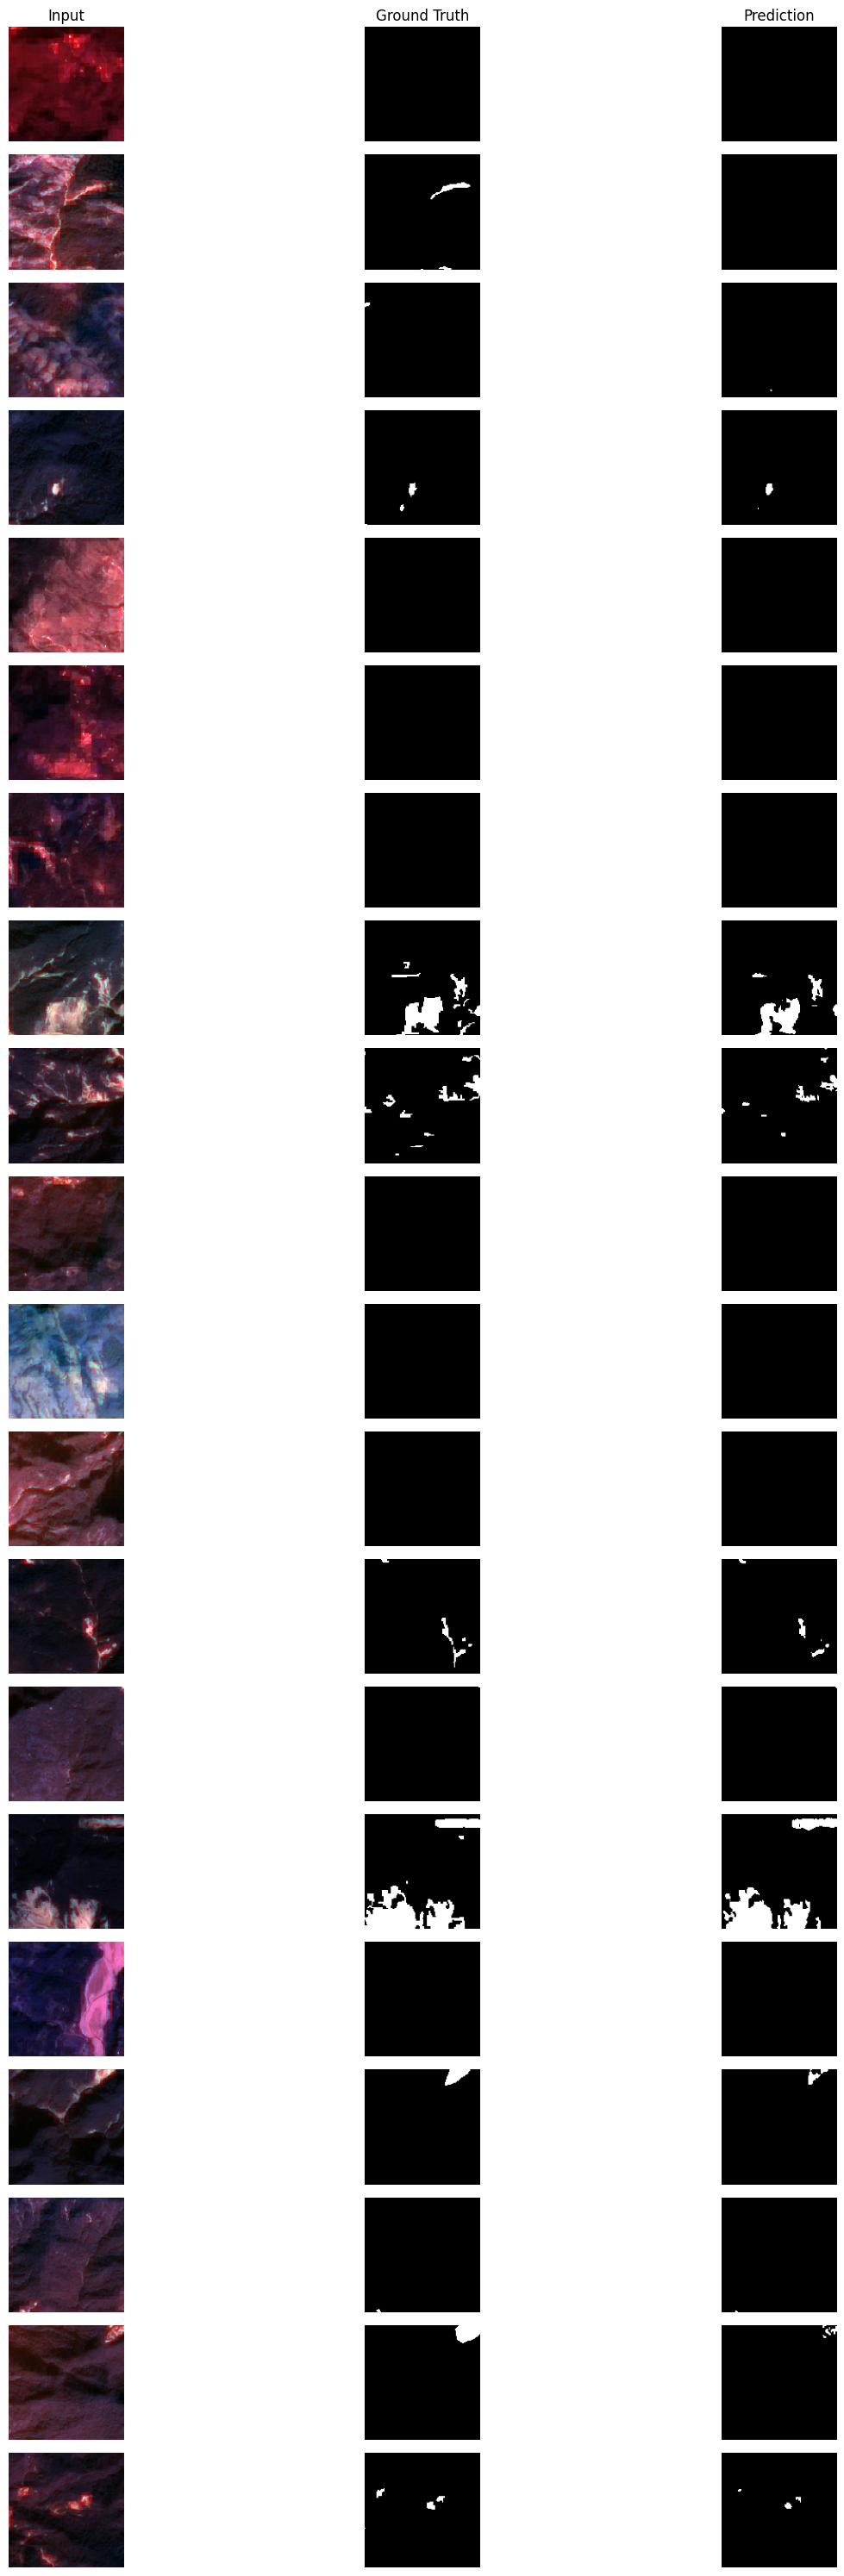

In [74]:
visualize_predictions_grid(model, valid_loader, device, num_batches=10, images_per_batch=2)

Keys: ['img']
(128, 128, 14) float64


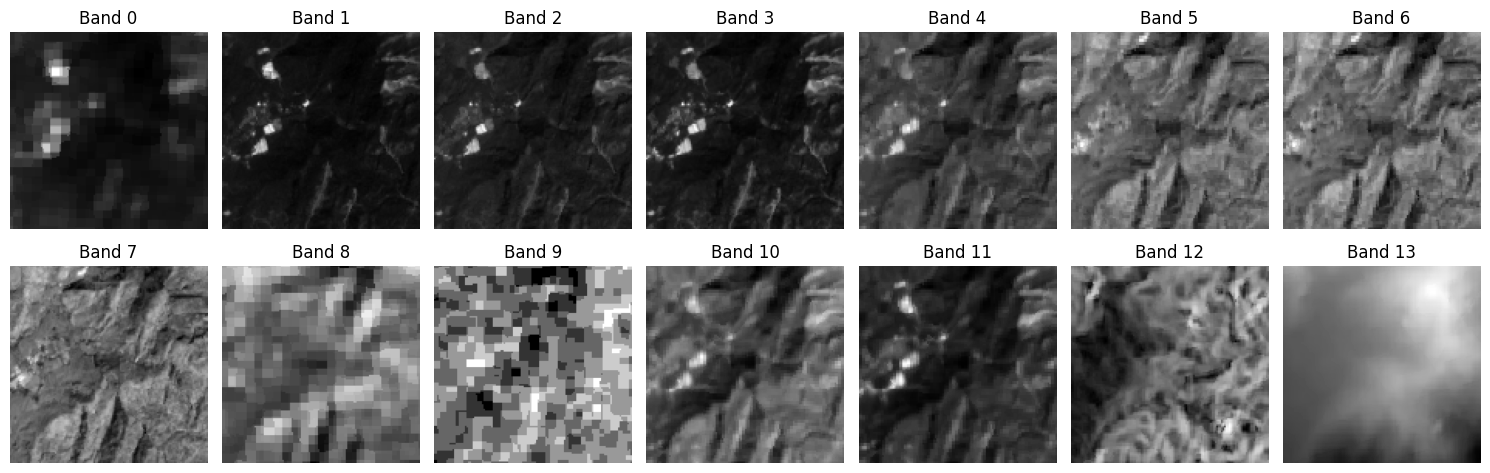

In [80]:
import h5py
import matplotlib.pyplot as plt
with h5py.File("/kaggle/input/landslide4sense-challenge/TrainData/img/image_1.h5", "r") as f:
    # List all groups/datasets
    print("Keys:", list(f.keys()))
    
    # Access a dataset
    imgs = f["img"][:]
    print(imgs.shape, imgs.dtype)
fig, axes = plt.subplots(2, 7, figsize=(15, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(imgs[:, :, i], cmap="gray")
    ax.set_title(f"Band {i}")
    ax.axis("off")

plt.tight_layout()
plt.show()

torch.Size([1, 14, 128, 128])
(128, 128)


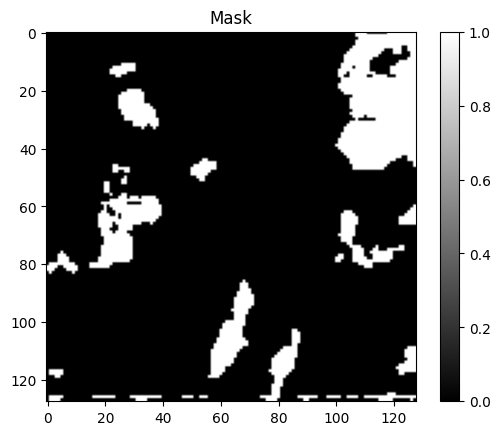

In [84]:
img_patch_tensor = torch.from_numpy(imgs).float()   # convert to float tensor
img_patch_tensor = img_patch_tensor.unsqueeze(0)    # add batch dimension -> (1,14,H,W)
img_patch_tensor = img_patch_tensor.to(device)      # move to GPU or CPU
img_patch_tensor = img_patch_tensor.permute(0, 3, 1, 2)  # (B,H,W,C) -> (B,C,H,W)

print(img_patch_tensor.shape)

model.eval()
with torch.no_grad():
    output = model(img_patch_tensor)          # (1,1,H,W)
    pred_mask = torch.sigmoid(output)  # probability
    pred_mask = (pred_mask > 0.5).float()
    mask = pred_mask.cpu().numpy().squeeze()
    mask = mask.astype(np.int32)  # convert float 0/1 mask to int
    
print(mask.shape)
plt.imshow(mask, cmap="gray")
plt.colorbar()
plt.title("Mask")
plt.show()

In [82]:
# Get x,y grid
rows, cols = dem.shape
X, Y = np.meshgrid(np.arange(cols), np.arange(rows))

# Flatten into point cloud
points = np.stack([X.flatten(), Y.flatten(), dem.flatten()], axis=1)  # (N,3)

print("Point cloud shape:", points.shape)

labels = mask.flatten()   # 0=stable, 1=landslide
print("Labels:", np.unique(labels))

Point cloud shape: (16384, 3)
Labels: [0 1]


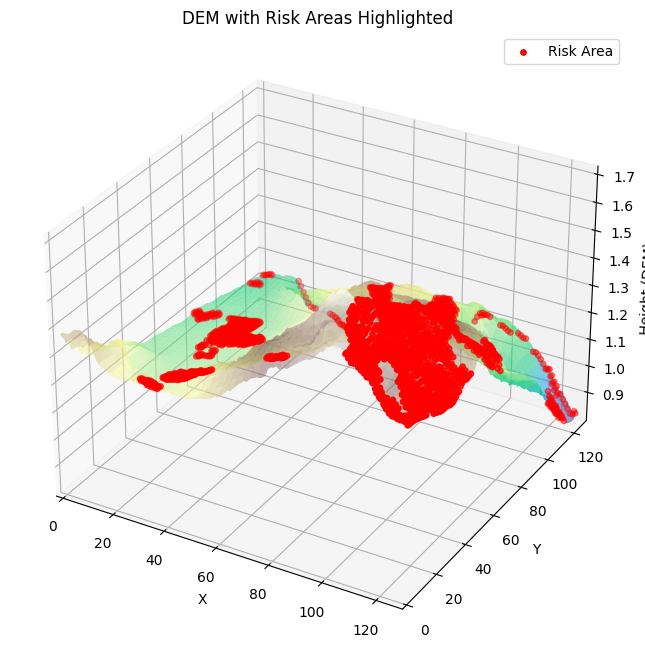

In [83]:
rows, cols = dem.shape
X, Y = np.meshgrid(np.arange(cols), np.arange(rows))

# Filter positive (risk) points
positive_mask = labels == 1
risk_points = points[positive_mask]

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

# Plot full DEM as semi-transparent surface
ax.plot_surface(X, Y, dem, cmap='terrain', alpha=0.5, edgecolor='none')

# Overlay risk points in red
ax.scatter(risk_points[:,0], risk_points[:,1], risk_points[:,2],
           c='red', marker='o', s=15, label="Risk Area")

# Set same scaling
ax.set_xlim(0, cols-1)
ax.set_ylim(0, rows-1)
ax.set_zlim(dem.min(), dem.max())

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Height (DEM)")
ax.set_title("DEM with Risk Areas Highlighted")
ax.legend()

plt.show()

Keys: ['img']
(128, 128, 14) float64


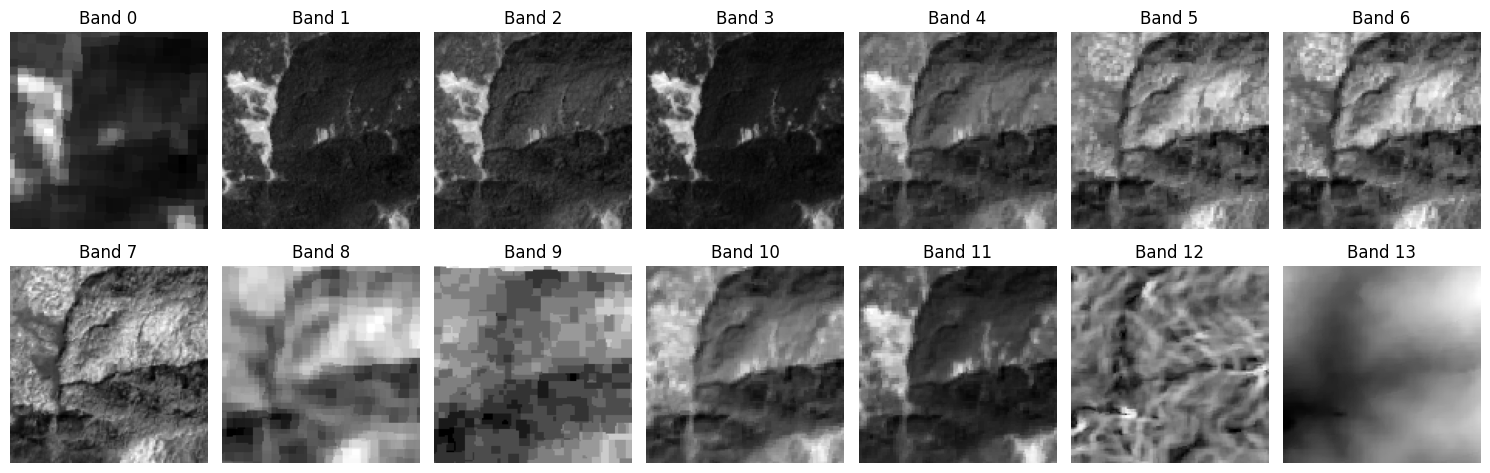

torch.Size([1, 14, 128, 128])
(128, 128)


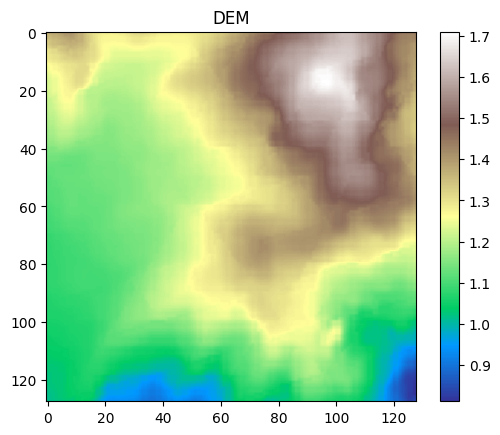

Point cloud shape: (16384, 3)
Labels: [0. 1.]


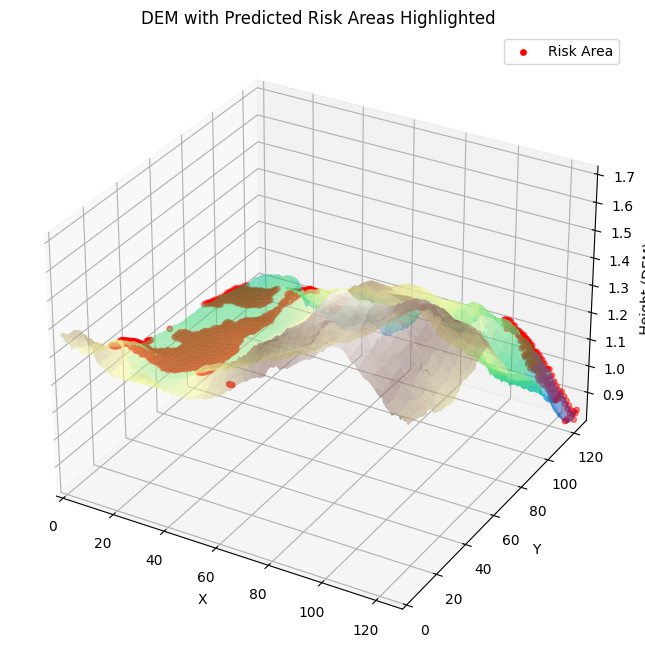

Keys: ['mask']


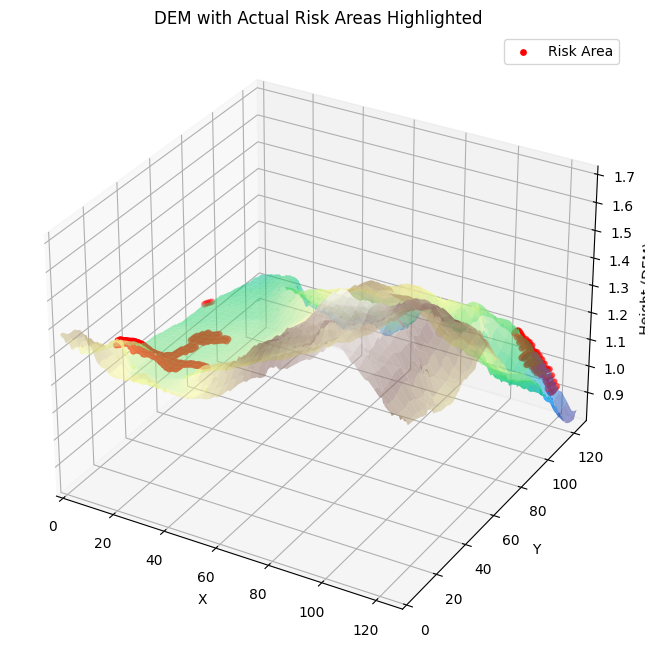

In [87]:
import h5py
import matplotlib.pyplot as plt
with h5py.File("/kaggle/input/landslide4sense-challenge/TrainData/img/image_100.h5", "r") as f:
    # List all groups/datasets
    print("Keys:", list(f.keys()))
    
    # Access a dataset
    imgs = f["img"][:]
    print(imgs.shape, imgs.dtype)
fig, axes = plt.subplots(2, 7, figsize=(15, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(imgs[:, :, i], cmap="gray")
    ax.set_title(f"Band {i}")
    ax.axis("off")

plt.tight_layout()
plt.show()

img_patch_tensor = torch.from_numpy(imgs).float()   # convert to float tensor
img_patch_tensor = img_patch_tensor.unsqueeze(0)    # add batch dimension -> (1,14,H,W)
img_patch_tensor = img_patch_tensor.to(device)      # move to GPU or CPU
img_patch_tensor = img_patch_tensor.permute(0, 3, 1, 2)  # (B,H,W,C) -> (B,C,H,W)

print(img_patch_tensor.shape)

model.eval()
with torch.no_grad():
    output = model(img_patch_tensor)          # (1,1,H,W)
    pred_mask = torch.sigmoid(output)  # probability
    pred_mask = (pred_mask > 0.7).float()
    mask = pred_mask.cpu().numpy().squeeze()

print(mask.shape)

plt.imshow(dem, cmap="terrain")
plt.colorbar()
plt.title("DEM")
plt.show()

# Flatten into point cloud
points = np.stack([X.flatten(), Y.flatten(), dem.flatten()], axis=1)  # (N,3)

print("Point cloud shape:", points.shape)

labels = mask.flatten()   # 0=stable, 1=landslide
print("Labels:", np.unique(labels))

rows, cols = dem.shape
X, Y = np.meshgrid(np.arange(cols), np.arange(rows))

# Filter positive (risk) points
positive_mask = labels == 1
risk_points = points[positive_mask]

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

# Plot full DEM as semi-transparent surface
ax.plot_surface(X, Y, dem, cmap='terrain', alpha=0.5, edgecolor='none')

# Overlay risk points in red
ax.scatter(risk_points[:,0], risk_points[:,1], risk_points[:,2],
           c='red', marker='o', s=15, label="Risk Area")

# Set same scaling
ax.set_xlim(0, cols-1)
ax.set_ylim(0, rows-1)
ax.set_zlim(dem.min(), dem.max())

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Height (DEM)")
ax.set_title("DEM with Predicted Risk Areas Highlighted")
ax.legend()

plt.show()
with h5py.File("/kaggle/input/landslide4sense-challenge/TrainData/mask/mask_100.h5", "r") as f:
    # List all groups/datasets
    print("Keys:", list(f.keys()))
    
    # Access a dataset
    mask = f["mask"][:]
labels = mask.flatten()
positive_mask = labels == 1
risk_points = points[positive_mask]
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

# Plot full DEM as semi-transparent surface
ax.plot_surface(X, Y, dem, cmap='terrain', alpha=0.5, edgecolor='none')

# Overlay risk points in red
ax.scatter(risk_points[:,0], risk_points[:,1], risk_points[:,2],
           c='red', marker='o', s=15, label="Risk Area")

# Set same scaling
ax.set_xlim(0, cols-1)
ax.set_ylim(0, rows-1)
ax.set_zlim(dem.min(), dem.max())

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Height (DEM)")
ax.set_title("DEM with Actual Risk Areas Highlighted")
ax.legend()
